In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Prepare data

### Dataset 2:

In [103]:
# Full grid evaluation data
full_sqr = []
for i in range(-20,21):
    full_sqr.append(0.1*i)
full_sqr = torch.tensor(full_sqr)
full_sqr = torch.cartesian_prod(full_sqr, full_sqr)

In [104]:
# Inner green circle
green_circ = []
for i in range(-20,21):
    green_circ.append(0.1*i)
green_circ = torch.tensor(green_circ)
green_circ = torch.cartesian_prod(green_circ, green_circ)
green_circ = [t for t in green_circ if np.linalg.norm(t)<=1.0]

In [105]:
# Outer red circle
red_circ = []
for i in range(-20,21):
    red_circ.append(0.1*i)
red_circ = torch.tensor(red_circ)
red_circ = torch.cartesian_prod(red_circ, red_circ)
red_circ = [t for t in red_circ if (np.linalg.norm(t)>=1.75 and np.linalg.norm(t)<=2.0)]

In [106]:
print(len(green_circ))
print(len(red_circ))
labels = [0 for i in range(len(green_circ))] + [1 for i in range(len(red_circ))]
coords = green_circ + red_circ

317
284


### Dataset 1:

In [57]:
# Full grid evaluation data
full_sqr = []
for i in range(-20,21):
    full_sqr.append(0.1*i)
full_sqr = torch.tensor(full_sqr)
full_sqr = torch.cartesian_prod(full_sqr, full_sqr)


In [58]:
# Inner green square data
green_sqr = []
for i in range(-9,10):
    green_sqr.append(0.1*i)
green_sqr = torch.tensor(green_sqr)
green_sqr = torch.cartesian_prod(green_sqr, green_sqr)
green_sqr = [torch.stack([x,y]) for [x,y] in green_sqr if abs(x)<=0.7 and abs(y)<=0.7]

In [59]:
# Outer red rectangle
red_sqr = []
for i in range(-13,14):
    red_sqr.append(0.1*i)
red_sqr = torch.tensor(red_sqr)
red_sqr = torch.cartesian_prod(red_sqr, red_sqr)
red_sqr = [torch.stack([x,y]) for [x,y] in red_sqr if not (abs(x)<=1.0 and abs(y)<=1.0)]

In [61]:
print(len(green_sqr))
print(len(red_sqr))
labels = [0 for i in range(len(green_sqr))] + [1 for i in range(len(red_sqr))]
coords = green_sqr + red_sqr

225
288


### Dataset/DataLoader

In [107]:
from torch.utils.data import Dataset, DataLoader

class PointDataset(Dataset):
    def __init__(self, coords, labels):
        self.coords = coords
        self.labels = labels
    def __getitem__(self, index):
        label = torch.zeros(2)
        label[self.labels[index]] = 1
        return self.coords[index], label
    def __len__(self):
        return len(self.coords)

In [108]:
dataset = PointDataset(coords, labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, drop_last=False)

### Create simple NN and optimizer

In [109]:
import torch.nn.functional as F

In [110]:
def show_params(model):
    for name, params in model.named_parameters():
#         if name.endswith('bias'):
#             params.data -= 1.0
    #     if params.requires_grad:
        print(name)
        print(params.data)
        print()
        
def add_bias(model):
    for name, params in model.named_parameters():
        if name.endswith('bias'):
            params.data += 1.0

### Train loop

In [127]:
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(2,3),
    nn.ReLU(),
    nn.Linear(3,2),
#     nn.Softmax(dim=1)
)
# Use for Dataset 1: add_bias(model)
# learning_rate:0.01, momentum:0.1, batch_size:10, l2_decay:0.001
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1, weight_decay=0.001)
# show_params(model)

In [128]:
model.train()
for epoch in range(201):
    for points,labels in dataloader:
        optimizer.zero_grad()
#         print(f"points = {points}")
#         print(f"labels = {labels}")
        logit_preds = model(points)
        loss = F.cross_entropy(logit_preds, labels)
        loss.backward()
        optimizer.step()
    if epoch%10==0:
        print(float(loss))
#         show_params(model)

0.8304674625396729
0.590918779373169
0.8338614702224731
0.388996422290802
0.23486806452274323
0.21047398447990417
0.2092609405517578
1.2549431324005127
1.818260669708252
1.2272474765777588
0.12933865189552307
0.012735464610159397
0.2373497635126114
0.2318294495344162
0.22151726484298706
0.016676196828484535
0.037506721913814545
0.11847473680973053
0.010805902071297169
0.11433007568120956
0.0493583008646965


In [129]:
model.eval()
green_preds = []
red_preds = []
for point in full_sqr:
    with torch.no_grad():
        point = torch.unsqueeze(point, 0)
        logits = model(point)[0]
        probs = F.softmax(logits,dim=0)
#         print(f"logits={logits}")
#         print(probs)
        if probs[0]>=probs[1]:
            green_preds.append(torch.squeeze(point))
        else:
            red_preds.append(torch.squeeze(point))
# show_params(model)

## Dataset 2: Circle

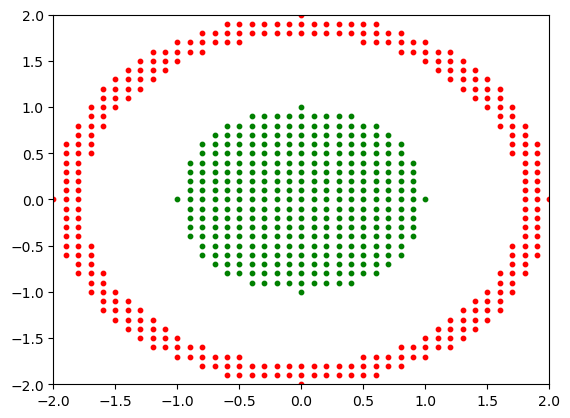

In [130]:
plt.axis([-2.0, 2.0, -2.0, 2.0])
plt.scatter(torch.stack(green_circ)[:,0], torch.stack(green_circ)[:,1],c='green', s=10)
plt.scatter(torch.stack(red_circ)[:,0], torch.stack(red_circ)[:,1],c='red',s=10)

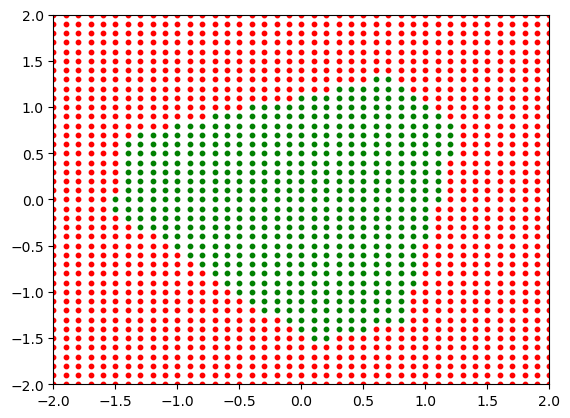

In [131]:
plt.axis([-2.0, 2.0, -2.0, 2.0])
plt.scatter(torch.stack(green_preds)[:,0], torch.stack(green_preds)[:,1],c='green', s=10)
plt.scatter(torch.stack(red_preds)[:,0], torch.stack(red_preds)[:,1],c='red', s=10)

In [132]:
show_params(model)

0.weight
tensor([[ 2.2073, -0.4897],
        [-1.4752, -1.6321],
        [-0.6496,  2.0777]])

0.bias
tensor([-0.9715, -0.9149, -0.8010])

2.weight
tensor([[-1.6584, -1.3337, -1.3917],
        [ 1.7072,  1.9719,  1.8006]])

2.bias
tensor([ 2.4065, -2.5301])



In [ ]:
'''
0.weight
tensor([[ 2.2073, -0.4897],
        [-1.4752, -1.6321],
        [-0.6496,  2.0777]])

0.bias
tensor([-0.9715, -0.9149, -0.8010])

2.weight
tensor([[-1.6584, -1.3337, -1.3917],
        [ 1.7072,  1.9719,  1.8006]])

2.bias
tensor([ 2.4065, -2.5301])

'''

In [ ]:
# Graphs of intermediate functions for Dataset 2

# hidden 1,2,3
\max \left(0,2.2073x-0.4897y-0.9715\right)
\max \left(0,-1.4752x-1.6321y-0.9149\right)
\max \left(0,-0.6496x+2.0777y-0.801\right)

# green logit
-1.6584\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)-1.3337\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)-1.3917\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)+2.4065

# red logit
1.7072\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)+1.9719\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)+1.8006\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)-2.5301

# green probability
\frac{e^{-1.6584\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)-1.3337\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)-1.3917\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)+2.4065}}{e^{-1.6584\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)-1.3337\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)-1.3917\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)+2.4065}+e^{1.7072\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)+1.9719\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)+1.8006\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)-2.5301}}

# red probability
\frac{e^{1.7072\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)+1.9719\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)+1.8006\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)-2.5301}}{e^{-1.6584\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)-1.3337\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)-1.3917\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)+2.4065}+e^{1.7072\cdot \max \left(0,2.2073x-0.4897y-0.9715\right)+1.9719\cdot \max \left(0,-1.4752x-1.6321y-0.9149\right)+1.8006\cdot \max \left(0,-0.6496x+2.0777y-0.801\right)-2.5301}}

## Dataset 1: Contained rectangle

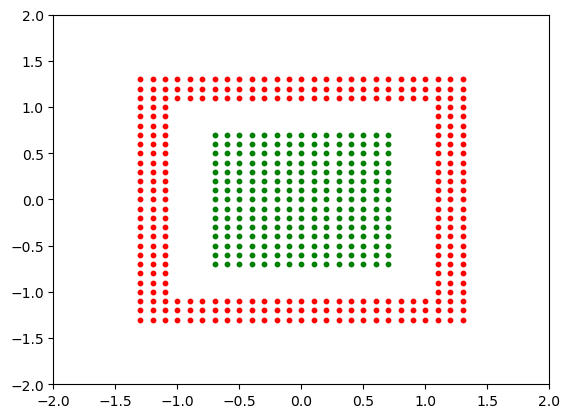

In [82]:
plt.axis([-2.0, 2.0, -2.0, 2.0])
plt.scatter(torch.stack(green_sqr)[:,0], torch.stack(green_sqr)[:,1],c='green', s=10)
plt.scatter(torch.stack(red_sqr)[:,0], torch.stack(red_sqr)[:,1],c='red',s=10)

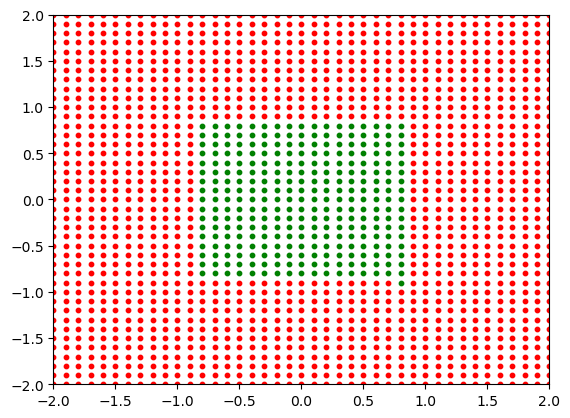

In [83]:
plt.axis([-2.0, 2.0, -2.0, 2.0])
plt.scatter(torch.stack(green_preds)[:,0], torch.stack(green_preds)[:,1],c='green', s=10)
plt.scatter(torch.stack(red_preds)[:,0], torch.stack(red_preds)[:,1],c='red', s=10)

In [84]:
show_params(model)

0.weight
tensor([[-2.8300, -2.8441],
        [-2.6881,  0.0216],
        [-2.7883,  2.8599]])

0.bias
tensor([-0.0692,  3.0416, -0.0494])

2.weight
tensor([[-2.5839,  2.7774, -2.6622],
        [ 3.0145, -2.9333,  2.9574]])

2.bias
tensor([-1.3767,  2.3159])



In [52]:
# Previous training run
# 0.weight
# tensor([[ 2.7427,  2.8161],
#         [ 2.7780, -2.7934],
#         [ 2.6480,  0.0222]])

# 0.bias
# tensor([-0.0525, -0.0723,  2.9888])

# 2.weight
# tensor([[-2.8163, -2.7755,  2.9952],
#         [ 2.7369,  2.7678, -2.6336]])

# 2.bias
# tensor([-1.7292,  1.8008])


In [ ]:

#green probability
\frac{e^{-2.8163\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)-2.7755\cdot \max \left(0,2.778x-2.7934y-0.0723\right)+2.9952\cdot \max \left(0,2.648x+0.0222y+2.9888\right)-1.7292}}{e^{-2.8163\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)-2.7755\cdot \max \left(0,2.778x-2.7934y-0.0723\right)+2.9952\cdot \max \left(0,2.648x+0.0222y+2.9888\right)-1.7292}+e^{2.7369\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)+2.7678\cdot \max \left(0,2.778x-2.7934y-0.0723\right)-2.6336\cdot \max \left(0,2.648x+0.0222y+2.9888\right)+1.8008}}

# red probability
\frac{e^{2.7369\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)+2.7678\cdot \max \left(0,2.778x-2.7934y-0.0723\right)-2.6336\cdot \max \left(0,2.648x+0.0222y+2.9888\right)+1.8008}}{e^{-2.8163\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)-2.7755\cdot \max \left(0,2.778x-2.7934y-0.0723\right)+2.9952\cdot \max \left(0,2.648x+0.0222y+2.9888\right)-1.7292}+e^{2.7369\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)+2.7678\cdot \max \left(0,2.778x-2.7934y-0.0723\right)-2.6336\cdot \max \left(0,2.648x+0.0222y+2.9888\right)+1.8008}}

# red logit
2.7369\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)+2.7678\cdot \max \left(0,2.778x-2.7934y-0.0723\right)-2.6336\cdot \max \left(0,2.648x+0.0222y+2.9888\right)+1.8008

# green logit
-2.8163\cdot \max \left(0,2.7427x+2.8161y-0.0525\right)-2.7755\cdot \max \left(0,2.778x-2.7934y-0.0723\right)+2.9952\cdot \max \left(0,2.648x+0.0222y+2.9888\right)-1.7292

# hidden units 1,2,3
\max \left(0,2.7427x+2.8161y-0.0525\right)
\max \left(0,2.778x-2.7934y-0.0723\right)
\max \left(0,2.648x+0.0222y+2.9888\right)